
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Metodos Estadisticos</p>

<p align="center"> Código Curso: 203008067 </p>

<p align="center"> Grupo: 7 </p>

 <p align="center">  Tarea 2: Aprendizaje Estadistico Supervisado </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Mireya García García </p>

 <p align="center"> 29/10/2024 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar conocimientos de aprendizaje automatico y de estadistica, usando métodos de regresión lineales y lineales generalizados, para la modelación del precio de viaje de una empresa de transporte.

# Objetivos Especificos

### Construir tres modelos: uno de regresion lineal, regresion lineal multiple y logistico, usando métodos de aprendizaje automatico supervisado, para la implementación de un modelo de costo dinamico de transporte.

### Construir graficos de dispersion, regresion y de residuos, usando los datos predichos por los diferentes modelos, para la revisión grafica de la idoneidad de los métodos usados.  

### Examinar la calidad de los modelos elaborados usando diversas metricas y la prueba estadistica t-student, para determinar cual es el más idoneo para la predicción del costo.

# Importar librerias

In [1]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, binarize, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
formato = "{:.3f}"
pd.options.display.float_format = formato.format

# Funciones para Metricas:

Se definen varias funciones de conveniencia para los calculos de las métricas de modelos, y para los calculos de las pruebas estadisticas.

In [2]:
def mostrar_parametros(variables, modelo, valores_t, valores_p, nombre_parametros="parametros"):
    """
    Contruir un dataframe para mostrar los resultados de un modelo de regresion.
    muestra los nombres de las variables, valores de parametros estimados,
    valores t y valores p.
    """
    summ = pd.DataFrame(
        {"variables":[*variables, "intercepto"], 
        "parametros":[*modelo.coef_.ravel(), *modelo.intercept_.ravel()],
        "valores t": valores_t,
        "valores_p": valores_p
        })

    return summ
        
def mostrar_metricas(y_real, y_predicho, decimales = 4, num_predictores=None):
    """
    Mostrar un tabla con resultados  de medidas de resumen de ajuste de
    modelos: calcula el MSE, RMSE, R2, MAE, R2_aj
    """ 
   # calculo del R cuadrado
    r2 = metrics.r2_score(y_real, y_predicho)
    
    summ = [ f"R2    : {r2:.{decimales}f}", ]

    # calculo R2 cuadrado ajustado, si se pasa un numero de predictores
    if num_predictores is not None:
        n = y_real.size
        
        r2_adj = 1 - ( (1 - r2) * (n - 1) ) / (n - num_predictores - 1) 

        summ.append(f"R2_adj: {r2_adj:.{decimales}f}")

    # Calculo de metricas MSE, RMSE, MAE
    
    mse = metrics.mean_squared_error(y_real, y_predicho)
    
    rmse = np.sqrt(mse)
 
    mae =  metrics.mean_absolute_error(y_real, y_predicho)
    
    summ.extend(
        (
        f"MSE   : {mse:.{decimales}f}",
        f"RMSE  : {rmse:.{decimales}f}",
        f"MAE   : {mae:.{decimales}f}",
        ))

    return "\n".join(summ)
    
    

def calcular_valor_t(X, y_real, y_pred, estadistico_estimado, estadistico_esperado):
    """
    Calcular valores t, comparando los valores estimados de un estadistico vs los valores
    esperados. se calculan los valores t y lo valores p correspondientes.
    """

    # obtener cantidad de puntos de datos
    n = y_real.shape[0]

    # calculo de resiudos, despues de haber entrenado un modelo 
    residuos = y_real - y_pred

    # Calculo de la desviacion estandar de los residuos. 
    # grado de libertad n-2 por ser un modelo regresion
    
    SC = residuos ** 2 

    std_residuos = np.sqrt(SC.sum()/(n - 2))

    # calculo de la desviacion estandar de las caracteriscas

    std_X = X.values.std()

    # calculo del error estandar. se invierte para usarlo directamente despues

    inv_std_error = (np.sqrt(n - 1)/std_residuos) * (std_X)

    # calculo del estadisticos t y p,  con t = (m_estimado - m_esperado)/error_estandar
    valor_t = (estadistico_estimado - estadistico_esperado) * inv_std_error

    valor_p = stats.t.sf(np.abs(valor_t), df= n - 2) * 2

    return valor_t, valor_p


# Funciones para Visualización:

Se definine varias funciones para graficar las predicciones de los modelos, y visualizar metricas

In [3]:
def grafico_linear_simple(x_entre, y_entre, x_prueba, y_prueba, modelo, titulo, titulo_x, titulo_y):
    plt.scatter(x_entre, y_entre, color="c", label="entrenamiento")
    
    plt.scatter(x_prueba, y_prueba, color="r", label="prueba")

    x_reg = np.linspace(np.min(x_entre), np.max(x_entre), 300).reshape(-1, 1)
    y_reg = modelo.predict(x_reg)
    
    plt.plot(x_reg, y_reg, "k--", label="linea regresión")

    plt.title(titulo)

    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()

    # Mostrar el gráfico
    plt.show()


def grafico_real_vs_predicho(y_prueba, y_prueba_pred, titulo, titulo_x, titulo_y):
    linea = np.linspace(np.min(y_prueba_pred), np.max(y_prueba_pred), 300)
    
    plt.plot(linea, linea, color='k', linestyle='--', label='y = x')
    
    plt.scatter(y_prueba, y_prueba_pred, color="c")
    
    plt.title(titulo)
    
    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()
    
    # Mostrar el gráfico
    plt.show()

def grafico_residuos(y_real, y_predicho, titulo, titulo_x, titulo_y, color="g"):
    """
    Calcular y graficar residuos de un modelo de regresion versus los valores
    predichos.
    """
    fig = plt.figure()

    ax = fig.add_subplot()

    residuos = y_real - y_predicho
    
    ax.scatter(y_predicho, residuos, color=color, alpha=0.6)

    ax.axhline(y=0, color="k", linestyle="--")

    ax.set_title(titulo)

    ax.set_xlabel(titulo_x)

    ax.set_ylabel(titulo_y)

    plt.show()
    

def matriz_confusion(y_real, y_predicho):
    matriz = metrics.confusion_matrix(y_real, y_predicho)
    
    heatmap(matriz, "Matriz Confusion", "d")
    
    ax = plt.gca()
    
    ax.set_xlabel("Valor Predicho")
    
    ax.set_ylabel("Valor Real")


def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    """
    Presentar un vision grafica de una matrix, com un mapa de calor.
    """
    plt.figure(figsize=tamaño)
    
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    
    plt.title(titulo)


# Variables:

Las siguientes clases definen enumeraciones. Su función es simplemente contener constantes en un solo conjunto, para evitar los errores en el codigo.

In [4]:
# Variables categoricas del dataset
class Categ(Enum):
    locacion = "Location_Category"
    lealtad = "Customer_Loyalty_Status"
    tiempo_viaje = "Time_of_Booking"
    vehiculo = "Vehicle_Type"

# Variables numericas del dataset
class Num(Enum):
    viajes_pasados = "Number_of_Past_Rides"
    puntaje_promedio = "Average_Ratings"
    pasajeros = "Number_of_Riders" 	
    conductores = "Number_of_Drivers"
    duracion_esperada = "Expected_Ride_Duration"
    costo_historico = "Historical_Cost_of_Ride"

# Limpieza de datos

Se realiza el cargue de los datos, y se eliminan los datos nulos: 

In [5]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('Anexo 1- Base de Datos dynamic_pricing.csv')

df_crudo.drop_duplicates()

df_modelos = df_crudo.dropna()

# Pruebas estadisticas de regresiones:

La prueba estadistica por excelencia para probar la significancia de las regresiones halladas es la prueba *t - student*. Esta prueba se usa para probar si existen diferencias significativas entre dos poblaciones, usando algún estadistico para la prueba. Normalmente se usa las medias poblacionales, pero en este caso se usan los valores de los parametros de los modelos (pendientes en regresión lineal, pesos en regresion logistica). Las ecuaciones relevantes para la prueba son las siguientes:

- calculo valor t:

$$ t_s = \frac{b_{estimado} - b_{esperado}}{ET} $$ 

- calculo del error estandar:

$$ ET = \frac{s_{r}}{s_x * \sqrt{n - 1}} $$

- calculo Residuos:

$$ r = y_{real} - y_{predicho}$$

- desviación estandar residuos:

  $$ s_r = \sqrt{\frac{\sum^{n}_{i = 0}{r_i^2}}{n - 2}}$$

- desviación estandar :

$$ s_x = \sqrt{\frac{\sum^{n}_{i = 0}{x_i - \bar{x}}}{n - 1}}$$

En las anteriores ecuaciones: $n$ es el total de puntos de datos, $b_{estimado}$ es el parametro calculado y $b_{esperado}$ es el valor esperado para la hipotesis nula; $\bar{x}$ es el promedio calculado para la variable independiente; $y$ son los valores de la variable de respuesta. 

Se usan las siguientes hipotesis para realizar la prueba t - student, sobre cada uno de los parametros:

$$ H_0: b = 0 $$
$$ H_1: b \neq 0 $$

La hipotesis nula indica que no hay correlación entre la variable independiente y dependiente, y que los coeficientes esperados deberian ser cero. La hipotesis alternativa indica que si existe correlación, y que el coeficiente debe ser diferente de cero. Los valores $P$ se pueden calcular a partir de los valores $t$, teniendo en cuenta que los grados de libertad son de $n - 2$


# Regresion Lineal Simple

La regresión lineal simple se realiza ajustando una ecuación de recta, de una unica variable, a los datos en estudio:

$$ y = b_1 * x + b_0$$

$b_1$ es la pendiente de la recta, $b_0$ es el intercepto con el eje y. Esto son los parametros de ajuste del modelo, y normalmente se hallan por medio de un ajuste de minimos cuadrado. Para este trabajo, se uso la interface `LinearRegression` del paquete sklearn. Se hace una separación previa de los datos en entrenamiento y prueba, en proporciones $30 \% - 70 \%$. En cada caso se mencionan cuales variables se extraen del conjunto de datos para las diversas regresiones lineales.

In [8]:
from sklearn.linear_model import LinearRegression

In [6]:
# Dividir los datos en conjuntos de entrenamiento y prueba (70% entrenamiento y 30% prueba)

X_entre_lin, X_prueba_lin, y_entre_lin, y_prueba_lin = train_test_split(df_modelos,
                                                        df_modelos[Num.costo_historico.value], 
                                                        train_size=0.7,
                                                       random_state=600) 

viajes_entre = X_entre_lin[[Num.viajes_pasados.value]]
duracion_entre = X_entre_lin[[Num.duracion_esperada.value]]

viajes_prueba = X_prueba_lin[[Num.viajes_pasados.value]]
duracion_prueba = X_prueba_lin[[Num.duracion_esperada.value]]


## Costos Historico vs. Cantidad Viajes Pasados

### Ajuste del modelo:

In [9]:
#se crea el objeto de regresión lineal
modlin_viajes = LinearRegression()

# el modelo usando los datos de entrenamiento
modlin_viajes.fit(viajes_entre, y_entre_lin)

LinearRegression()

In [9]:
y_entre_pred = modlin_viajes.predict(viajes_entre)
y_prueba_pred = modlin_viajes.predict(viajes_prueba)

### Visualización:

C:\Users\sopor\miniconda3\envs\ds\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


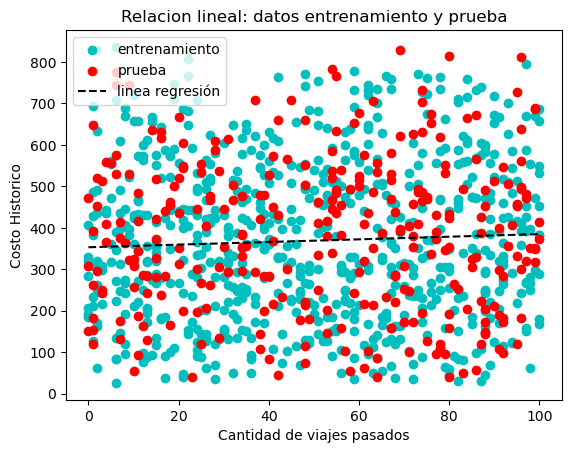

In [10]:
grafico_linear_simple(viajes_entre, y_entre_lin, 
                      viajes_prueba, y_prueba_lin, 
                      modlin_viajes,
                      'Relacion lineal: datos entrenamiento y prueba', 
                      'Cantidad de viajes pasados',
                      'Costo Historico'
                     )

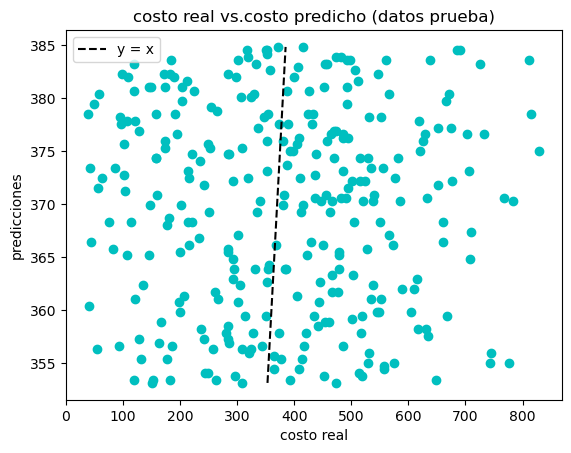

In [17]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred, 
                         'costo real vs.costo predicho (datos prueba)',
                         'costo real',
                         "predicciones"
                        )

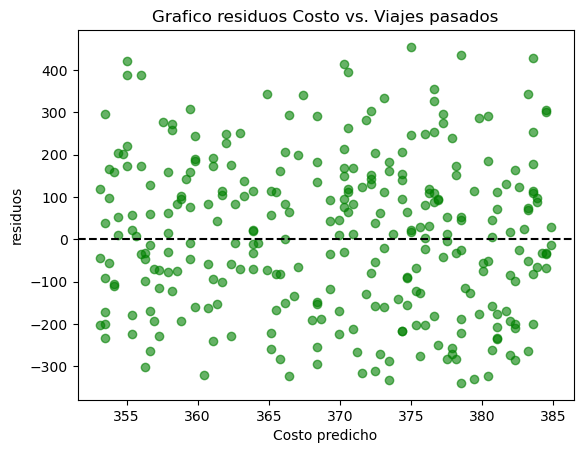

In [18]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Costo vs. Viajes pasados", 
                 "Costo predicho", 
                 "residuos")

### Analisis:

El gráfico de dispersión de los datos muestra que estos estan distribuidos aleatoriamente sin seguir ninguna tendencia. La linea de regresión no esta mostrandon ninguna correlación entre las variables dependiente e independiente. El grafico indicaria que no habia correlación lineal entre las variables en primer lugar.

El gráfico de predicciones vs. valores reales tambien muestran que los puntos estan distribuidos por todo el grafico. Este deberia mostrar los puntos seguiendo la tendencia simetrica de $y = x$, pero no esta pasando. Este grafico muestra que el modelo hallado no puede predecir el costo real.

El gráfico de Residuos no parece mostrar tendencias ni patrones. Esto indica que los datos estan distribuidos aleatoriamente. Esto significa que el análisis estadistico posterior no pierde generalidad, ya que se cumple el criterio de homocesdasticidad.

### Metricas y Parametros:

In [14]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=1))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=1))

metricas entrenamiento:
R2    : 0.0024
R2_adj: 0.0009
MSE   : 35665.2333
RMSE  : 188.8524
MAE   : 158.8371
metricas prueba:
R2    : -0.0067
R2_adj: -0.0100
MSE   : 33338.8161
RMSE  : 182.5892
MAE   : 151.8171


In [116]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modlin_viajes.coef_, modlin_viajes.intercept_)

valores_t, valores_p = calcular_valor_t(viajes_prueba, y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros([Num.viajes_pasados.value], modlin_viajes, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Past_Rides,0.317,0.895,0.372
1,intercepto,353.132,996.131,0.000


### Analisis:

La pendiente hallada de $0.317$ refleja en el modelo que el costo del viaje aumenta en 0.317 unidades monetarias por cada viaje pasado adicional. El intercepto mostraría un precio base para el costo de 353 unidades monetarias.

los valores de $R^2$ de $-0.67\%$, y $R^1_{adj}$  de $-1\%$, son negativos y bajos calculados en los datos de prueba. El RMSE ($182.58$) muestra un valor muy alto, indicando que la diferencia entre valores predichos y reales es muy alta. Todas estas metricas indican que el modelo es pesimo para predecir el costo. 

La prueba estadistica aplicada en los parametros muestra que la pendiente tiene un valor $P$ de 0.372, mucho mayor al limite de $0.05$. Por lo tanto, se acepta la hipotesis nula, indicando que no hay correlación entre el costo y el número de viajes pasados. el intercepto tiene un valor $P$ menor al limite, pero no tiene sentido tomarlo en cuenta si la pendiente no tiene significancial.


## Costos Historico vs. Duración Esperada del Viaje

### Ajuste del modelo:

In [10]:
#se crea el objeto de regresión lineal
modlin_duracion = LinearRegression()

# el modelo usando los datos de entrenamiento
modlin_duracion.fit(duracion_entre, y_entre_lin)

LinearRegression()

In [11]:
y_entre_pred  = modlin_duracion.predict(duracion_entre)
y_prueba_pred = modlin_duracion.predict(duracion_prueba)

### Visualización:

C:\Users\sopor\miniconda3\envs\ds\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


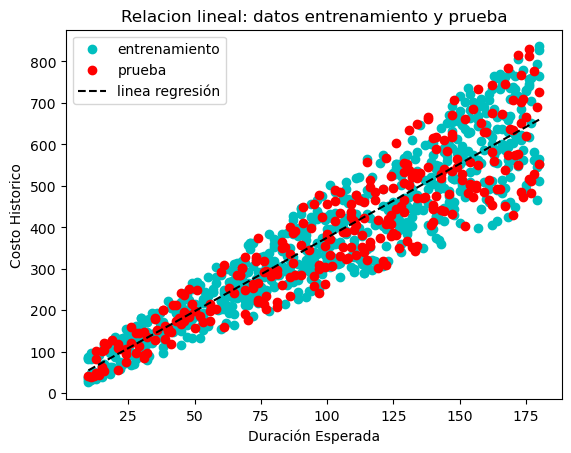

In [21]:
grafico_linear_simple(duracion_entre, y_entre_lin, 
                      duracion_prueba, y_prueba_lin,
                      modlin_duracion,
                      'Relacion lineal: datos entrenamiento y prueba',
                      'Duración Esperada',
                      'Costo Historico')

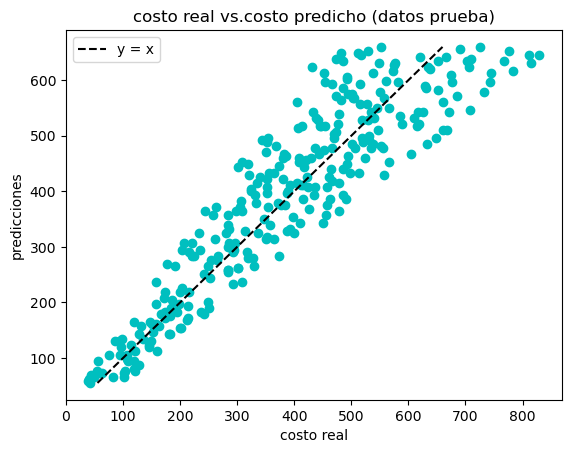

In [22]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred,
                         'costo real vs.costo predicho (datos prueba)',
                         'costo real',
                         'predicciones')

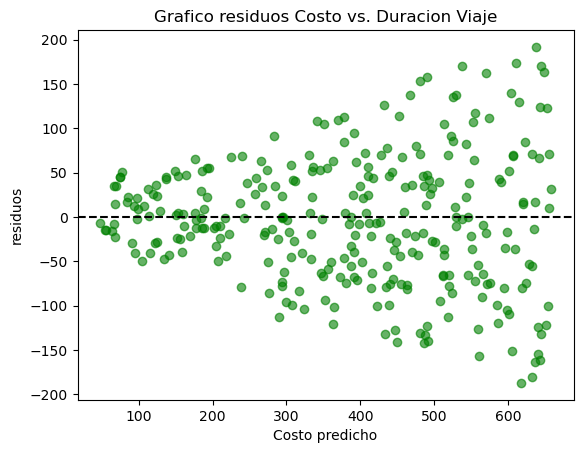

In [39]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Costo vs. Duracion Viaje", 
                 "Costo predicho", 
                 "residuos")

### Analisis:

El gráfico de dispersión de los datos muestra que estos siguen una tendencia creciente, y la recta de regresion refleja la tendencia, en los datos de prueba y de entrenamiento. Esto indica que el modelo es capaz de ajustar los datos. 

El gráfico de predicciones vs. valores reales muestran que siguen la tendencia de la recta simetrica de $y = x$. Esta grafica muestra que las predicciones se acercan a los valores reales en todo el rango de valores. Tambien se observa que los valores siguen más de cerca la recta cuando son bajos, y a medida que aumenta el valor del costo real aumenta la desviación desde la recta.

El gráfico de residuos muestra que hay una distribución de los residuos alrededor del la linea cero. Los residuos positivos paracen aumentar con el aumento del costo predicho, y los residuos negativos parecen disminuir con el aumento del costo predicho. Esto indica que no se distribuyen los errores de forma aleatoria, no se cumple estrictamente el criterio de homocedasticidad, y no se cumplen los requerimientos para la prueba estadistica t-student sobre los coeficientes del modelo lineal.

### Metricas y Parametros:

In [14]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=1,))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=1))

metricas entrenamiento:
R2    : 0.8679
R2_adj: 0.8677
MSE   : 4723.3977
RMSE  : 68.7270
MAE   : 54.5048
metricas prueba:
R2    : 0.8406
R2_adj: 0.8400
MSE   : 5280.1836
RMSE  : 72.6649
MAE   : 57.5641


In [37]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modlin_duracion.coef_, modlin_duracion.intercept_)

valores_t, valores_p = calcular_valor_t(duracion_prueba, y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros([Num.duracion_esperada.value], modlin_duracion, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Expected_Ride_Duration,3.557,40.695,0.000
1,intercepto,19.595,224.181,0.000


### Analisis:

La pendiente hallada de $3.357$ nos dice que el costo aumenta en 3.357 unidades monetarias, por cada minuto que aumente la duración esperada del viaje. El intercepto mostraria un cosoto base de 19.59 unidades monetarias por un viaje. 

En los datos de prueba, Las metricas de $R^2$ y $R^2_{adj}$ tienen el valor de $84\%$. El RMSE ($72$) es un valor bajo comparado con las magnitudes del costo, mostrando una baja desviación entre predicciones y valores reales. Este modelo es mucho mejor en ajustar los datos y en predecir el costo.

La prueba estadistica aplicada en los parametros muestra que la pendiente tiene un valor $P$ muy cercano a cero, y debajo del limite. Por lo tanto, se rechazaria la hipotesis nula, indicando que hay correlación lineal entre el costo y la duración esperada del viaje. Sin embargo, el analisis del grafico de residuos revela que los residuos no estan distribuidos de forma aleatoria, quitandole generalidad a la prueba estadistica. Esto no significa necesariamente que los resultados del modelo sean incorrectos, pero que se necesitan hacer modificaciones al setup del modelo para que se cumpla el criterio de homocedasticidad. 


# Regresion Lineal Multiple

La regresión lineal multiple es una generalización de la simple: se realiza ajustando una ecuación lineal de multiples variables a los datos en estudio, de acuerdo a la siguiente ecuación:

$$ y = \beta_1 \cdot X + b_0$$

$X$ es un vector conteniendo las variables independientes, $\beta_1$ es el vector conteniendo las pendientes para cada variable, y  $b_0$ es el intercepto con el eje y. Los parametros se ajustan de forma semejante al caso simple, por medio de un ajuste de miniumos cuadrados. La interfaz `LinearRegression` Tambien puede usarse para realizar regresiones lineales multiples, siempre y cuando todas las variables sean numericas. En este caso, tambien se hace una division de los datos en proporciones $30 \% - 70 \%$; y se usan las siguientes caracteristicas como variables independientes: 

- Cantidad de pasajeros en el área.
- Cantidad de conductores en el área.
- Cantidad de viajes pasado.
- Duración esperada del viaje.

### Ajuste del modelo:

In [34]:
caracteristicas = [Num.pasajeros.value, Num.conductores.value, Num.viajes_pasados.value, Num.duracion_esperada.value]

modmul = LinearRegression()

modmul.fit(X_entre_lin[caracteristicas], y_entre_lin)

LinearRegression()

In [35]:
y_entre_pred = modmul.predict(X_entre_lin[caracteristicas])
y_prueba_pred = modmul.predict(X_prueba_lin[caracteristicas])

### Visualización:

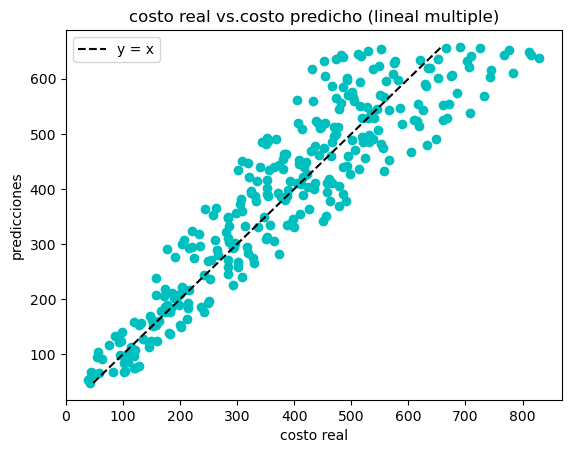

In [36]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred,
                         'costo real vs.costo predicho (lineal multiple)',
                         'costo real',
                         'predicciones')

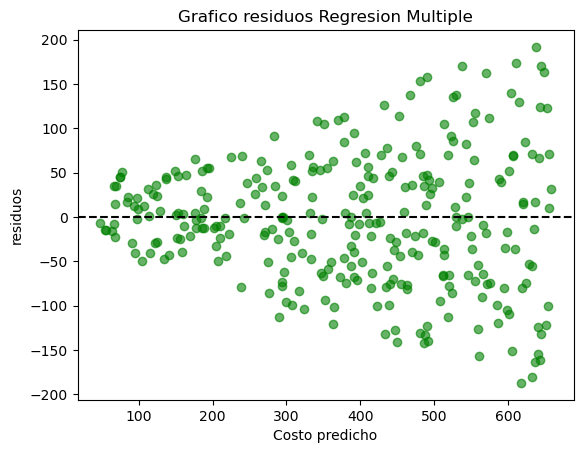

In [37]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Regresion Multiple", 
                 "Costo predicho", 
                 "residuos")

### Analisis:

El gráfico de predicciones vs. valores reales sigue la tendencia de la recta $y = x$. Muestra que el modelo lineal multiple es capaz de predecir los valores del costo. La dispersión de los puntos es similar al modelo linea de *Costo vs. duración esperada*. Como tambien se esta incluyendo la variable de *duración esperada del viaje* en el modelo, tiene sentido que las graficas de regresión se parezcan.

El gráfico de residuos muestra que hay una tendencia de los errores, similar a la que se presento en el modelo *Coso vs. duración esperada*. Esto muestra que la tendencia de los errores se deebe unicamente a la inclusión de la variable de *duración esperada del viaje*. Tampoco se cumple el criterio de homocestadicidad, lo que limita el analisis de las pruebas estadisitcas aplicadas. 

### Metricas y Parametros:

In [39]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=4))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=4))

metricas entrenamiento:
R2    : 0.8697
R2_adj: 0.8689
MSE   : 4659.3354
RMSE  : 68.2593
MAE   : 53.8421
metricas prueba:
R2    : 0.8416
R2_adj: 0.8395
MSE   : 5244.8792
RMSE  : 72.4215
MAE   : 57.3789


In [19]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modmul.coef_, modmul.intercept_)

valores_t, valores_p = calcular_valor_t(X_prueba_lin[caracteristicas], y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros(caracteristicas, modmul, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Riders,0.006,0.065,0.949
1,Number_of_Drivers,0.404,4.033,0.000
2,Number_of_Past_Rides,0.003,0.032,0.975
3,Expected_Ride_Duration,3.559,35.575,0.000
4,intercepto,7.862,78.587,0.000


### Analisis:

La coeficientes hallados son las pendientes, que se pueden interpretar cada una como:

- EL costo aumenta 0.006 unidades cuando el número de pasajeros disponibles en el área aumenta.
- El costo aumenta 0.404 unidades por cada conductor que haya disponible en el área.
- El costo aumenta 0.003 unidades por cada viaje que el vehiculo hay completado.
- El costo aumenta 3.559 unidades por cada minuto adicional que aumente la duración esperada.
- El intercepto muestra un costo base de 7.862.

La pendiente hallada para la duración esperada es muy cercana a la hallada en el modelo lineal simple.

En los datos de preuba, Las metricas de $R^2$ y $R^2_{adj}$ tienen el valor de $84.16\%$ y de $83.95\%$, estando muy cercanos entre ellos. El RMSE de ($72.42$) es un valor mucho menor comparado con la magnitud del costo, mostrando una baja desviación entre predicciones y valores reales. Este modelo predice bien el costo, y es ligeramente mejor que el lineal simple de *Costo vs. Duración esperada*.

La prueba estadistica revela que *El número de condutores disponibles* y *la duración esperada del viaje* son las unicas variables significativas del modelo, ya que estan bajo el umbral de $0.05$. Sin embargo, debido a los resultados vistos en la grafica de residuos, se pierde generalidad en la prueba estadistica, y tambien es necesario tomar acciones para reestablecer la homocesdasticidad.


# Regresión Logistica

La regresión Logistica es otro modelo lineal generalizado, que en lugar de ajustar directamente la variable dependiente, ajusta una probabilidad calculada a partir de la variable. Se debe usar en contextos donde es se requiera clasificación en clases, o donde la probabilidad misma se util. Esta probabilidad mide la que tan probable es que un punto de datos pertenezca a una clase especifica del modelo. La ecuación que define un modelo logistico es la siguiente:

$$ log(\frac{P}{1 - P}) = W^T \cdot X + b_0$$

$X$ es el vector conteniendo las variables independientes, $W$ es el vector conteniendo los pesos para cada variable, y  $b_0$ es una constante independiente (sesgo). Los parametros se ajustan de forma usando un mtodo iterativo para disminuir el error de ajuste, mediante el descenso del gradiente. La interfaz `LogisticRegression` del paquete `sklearn` se usa en este caso, soportando varias caracteristicas numericas, y respuesta binaria o muiltinomial. En este caso, tambien se hace una division de los datos en proporciones $30 \% - 70 \%$; y se usan las siguientes caracteristicas: 

- Area del pedido del viaje
- Categoria de lealtad del cliente
- Hora del dia del viaje
- Categoria del vehiculo

Los valores de estas variables no pueden ser usados directemente. Se tienen que trasnformar de una forma numerica, para que se conserve la información de las categorias. En este caso, se eligieron dos trasnformaciones: `OneHotEncoder` para las dos variables nominales, y `OrdinalEncoder` para las variables ordinales. 


- El `OrdinalEncoder` realiza un mapeo de las variables, para que sus niveles correspondan con niveles crecientes númericos.

- El `OneHotEncoder` separa la variable en sus varios niveles, para que los niveles se comporten como varias variables binarias, que pueden tener valores verdadero (1) o (falso) para la presencia del nivel.

Ambos encoders se agruparo en una clase llamada `ColumnTransformer`, y esta se agrupo junto con la clase `LogisticRegression`, usando una `Pipeline`. El objetivo de este proceso es el de poder realizar mas rapido el proceso en una unica serie de pasos, para evitar cometer errores.

Asi mismo, el puntaje como variable dependiente tampoco puede usarse directamente, ya que no se busca una predicción de la variable continua: se transforma primeramente en otra variable, llamada la *calidad del servicio*, de la siguiente forma :

- puntaje > 4 => servicio bueno (valor 1 en el modelo)

- puntaje <= 4 = > servicio malo (valor malo en el modelo)

Teniendo las variables transformadas de esta forma, se puede realizar el entrenamiento del modelo logistico:

### Ajuste del modelo:

In [20]:
from sklearn.linear_model import LogisticRegression

In [49]:
# caracteristicas que se mencionaron en el apartado anterior
caract_log = [Categ.locacion.value, Categ.tiempo_viaje.value, Categ.lealtad.value, Categ.vehiculo.value]

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

prep = ColumnTransformer([
    ('codificado_nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('codificado_ordinal', OrdinalEncoder(), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder= 'drop')

# La clase binarize permite dividir los datos en grupos de  1 y 0, dependiendo de cual sea el limite de la division. En este caso es cuatro
puntaje_limite = 4

calidad = binarize(df_modelos[[Num.puntaje_promedio.value]], threshold=puntaje_limite).ravel()

X_entre_log, X_prueba_log, calidad_entre, calidad_prueba = train_test_split(df_modelos[caract_log],
                                                        calidad, 
                                                        train_size=0.7,
                                                       random_state=600) 

In [50]:
#construyendo las variables para el nivel de produtividad (productividad alta: 1; productividad baja: 0)

modlog = Pipeline([
    ("preprocesamiento", prep),
    ("logistico", LogisticRegression())
])

modlog.fit(X_entre_log, calidad_entre)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificado_nominal',
                                                  OneHotEncoder(),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('codificado_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Customer_Loyalty_Status',
                                                   'Vehicle_Type'])])),
                ('logistico', LogisticRegression())])

In [51]:
calidad_entre_pred = modlog.predict(X_entre_log)
calidad_prueba_pred = modlog.predict(X_prueba_log)

El uso de los encoders para las variables categoricas ofusca cuales variables se estan usando realmente para el modelo. El siguiente fragmento es para extraer las caracteristicas usadas por el modelo, y poder presentarlas mas claramente

In [52]:
### fragmento de codigo para visualizar mejor a que variable corresponde cada parametro hallado
desglose_caract = []

encoder = modlog.named_steps["preprocesamiento"].transformers_[0][1]

for categ in encoder.categories_:
    desglose_caract.extend(categ)

desglose_caract.extend(caract_log[-2:])

### Radios Odd

In [53]:
parametros_log = np.append(modlog.named_steps["logistico"].coef_, modlog.named_steps["logistico"].intercept_)

radios_odd = pd.DataFrame({"variable": desglose_caract + ["intercepto"], 
                           "radios odd":np.exp(parametros_log)})

display(radios_odd)

,variable,radios odd
0,Rural,0.918
1,Suburban,1.025
2,Urban,1.053
3,Afternoon,1.168
4,Evening,0.721
5,Morning,1.270
6,Night,0.927
7,Customer_Loyalty_Status,0.959
8,Vehicle_Type,0.937
9,intercepto,2.362


### Analisis 

Los odd radios son la cantidad adimensional $\frac{P}{1-P}$ de la ecuación del modelo logistico. La expresion nos indica una relación sobre las probabilidades de la ocurrencia del evento, sobre la no ocurrencia. En este caso, el evento es que la calidad de viaje sea buena, y la ausencia del evento implica que la calidad del viaje sea mala. El odd radio se puede desglosar para cada uno de los parametros del modelo, y se interpretan de forma similar. Para el modelo presente seria:

- Para la variable locación del viaje:

> - Nivel Rural: indica que, en zona rural, es $0.918$ veces más probable que el servicio sea bueno, frente a que el servicio sea malo. Esto en realidad que implica que es $1/0.918 = 1.09$  veces mas probable que el servicio sea malo en zona rural.
> - Nivel Suburbano: indica que, en zona suburbana, es $1.025$ veces mas probable que el viaje sea bueno, respecto a que el viaje sea malo.
> - Nivel Urbano, En la zona urbana, es $1.053$ veces más probable que el servicio sea bueno, frente a que sea malo.

- Para la variable Hora del viaje:

> - Nivel tarde: En las horas de la tarde, es $1.168$ veces más probable que el servicio sea bueno, respecto a que sea malo.
> - Nivel anochecer: Pasa el mismo caso que en la variable locación. En realidad, al anochecher es $1/0.721 = 1.387$ veces más probable que el viaje sea malo, frente a que sea bueno.
> - Nivel Mañana: Es $1.27$ veces más probable que el viaje sea bueno, respecto a que sea malo, en las horas de la mañana.
> - Nivel Noche: En las horas de la noche, es $1/0.927 = 1.079$ veces mas probable que el servicio sea malo, frente a que el servicio sea bueno.

- Para la variable lealtad del cliente: la probabilidad de que el servicio sea malo es $1/0.959 = 1.043$ veces más probable respecto a que el servicio sea bueno. Como la variable es ordinal (0=clase oro, 1=clase plata, 2=clase regular), por cada nivel que aumente la lealtad, la probabilidad de que sea malo aumenta tambien.

Para la variable tipo de vehiculo: la probabilidad de que el servicio sea malo es $1/0.937 = 1.067$ veces más que la probabilidad sea bueno. Como la variable ses ordinal (0=premium, 1= economy), por cada nivel que aumente la variable, la probabilidad de que sea malo aumenta tambien.

### Metricas y Parametros:

In [54]:
acc_entre = metrics.accuracy_score(calidad_entre, calidad_entre_pred)
acc_prueba = metrics.accuracy_score(calidad_prueba, calidad_prueba_pred)

print(f"exactitud entrenamiento: {acc_entre:0.3f}", )
print(f"exactitud prueba: {acc_prueba:0.3f}")

exactitud entrenamiento: 0.683
exactitud prueba: 0.680


In [152]:
print(metrics.classification_report(calidad_prueba, calidad_prueba_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.68      1.00      0.81       204

    accuracy                           0.68       300
   macro avg       0.34      0.50      0.40       300
weighted avg       0.46      0.68      0.55       300



C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualización:

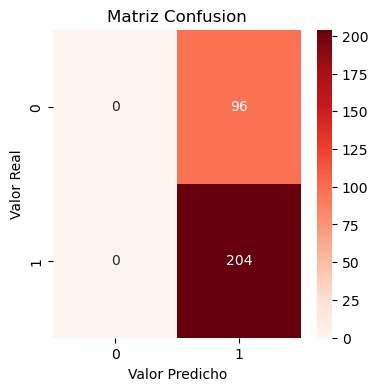

In [201]:
matriz_confusion(calidad_prueba, calidad_prueba_pred)

In [55]:
# pesos y sesgo, concatenados para el calculo del test t
caract_trans = pd.DataFrame(modlog.named_steps["preprocesamiento"].transform(X_prueba_log), columns=desglose_caract  )

valores_t, valores_p = calcular_valor_t(caract_trans, calidad_prueba, calidad_prueba_pred, parametros_log, 0)

mostrar_parametros(columnas, modlog.named_steps["logistico"], valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Rural,-0.085,-1.468,0.143
1,Suburban,0.024,0.421,0.674
2,Urban,0.052,0.896,0.371
3,Afternoon,0.155,2.664,0.008
4,Evening,-0.327,-5.623,0.000
5,Morning,0.239,4.116,0.000
6,Night,-0.076,-1.309,0.192
7,Customer_Loyalty_Status,-0.042,-0.728,0.467
8,Vehicle_Type,-0.065,-1.123,0.262
9,intercepto,0.860,14.784,0.000


### Analisis:

Las metricas de exactitud del modelo logistico muestran que fue capaz de predecir el $68\%$ de los datos de prueba, teniendo un precision alta. Sin embargo, observando las metricas de clasificación y la matrix de confusión del modelo, se puede observar que esa precision solo aplica a los valores de calidad buenos. El modelo es incapaz de predecir si se va a dar un servicio de calidad baja. Esto tambien ser refleja por los valores de recall y el  f1-score de cero para la variable baja: estas metricas no se calculan por que no hay predicciones para una calidad baja.

Las pruebas estadisticas sobre los parametros indican que las unicas variables que tienen significancia son las siguientes: 

- La variable de la hora dle viaje, en los niveles de la tarde, el anochecer y la mañana 

- la constante independiente que se agrega al modelo logistico.

Estos resultados, sin embargo, se ven limitados por la nula capacidad del modelo de poder predecir los casos de calidad baja.

## Conclusiones

### Regresion Lineal Simple

- El modelo de *Costo vs. viajes pasados* fue el que peor se desempeño entre todos los modelos, con un ajuste de $-0.68\%$. El modelo de *Costo vs. duración esperada* fue mejor que el anterior, teniendo un ajuste del $84\%$.

- Los resultados de la prueba estadistica del t-student permiten concluir que la variable de viajes pasados no tiene significancia en la predicción del costo. La prueba estadistica mostraria que la duración esperada si tiene significancia, pero esta conclusión se ve limitada por la falta de la homocedasticidad en el grafico de residuos. Se debe realizar una trasnformación de los datos para poder establecer que la varianza de los errores sea constante. Una de tales trasnformaciones para las regresiones lineales es la función logaritmica. Tambien es posible realizar una regresión lineal con pesos ponderados para evitar la varianza no constante.

### Regresion Lineal Multiple

- El modelo de regresión lineal multiple es el mejor de los construidos, teniendo un ajuste de $84.16\%$. El grafico valores predichos vs. valores reales mostraron igualmente que se dio un buen ajuste, y las demas metricas mostraron buenos resultados.

- El resultado de la prueba estadistica mostraria que las variables con significancia serian el número de conductores en el área, y la duración esperada del viaje. Sin embargo, pasa lo mismo que en el modelo anterior, donde la homocedasticidad no se observa en el grafico de residuos. En el caso del modelo linear multiple, tambien se pueden aplicar transformaciones a las variables para tener varianza constante, o el uso de una regresión lineal ponderada.

### Regresion Logistica

- El modelo logistico tuvo un ajuste menor al modelo lineal multiple, y superior al primer modelo lineal. tuvo una precisión del $68\%$, pero solo es capaz de predecir valores altos de la calidad. Esto se debe a que los datos en estan sesgados hacia valores altos de la calidad, por lo que se debe hacer un balanceo de los datos para mejorar el modelo

- Se encontró que solo los niveles de la variable de la hora de viaje son significativos en la predicción de la calidad. Sin embargo, estos resultados se ven limitados por la prescencia del desbalanceo de los datos.

## Enlaces Sustentación:

## [Diapositivas](https://view.genially.com/67206a039d6a5ac3863f8b56/presentation-informe-aprendizaje-estadistico)

## [Presentación](https://youtu.be/KnqF6oqtnYY)

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

